# Bengali Fake News Classification


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [5]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [6]:
from sklearn.model_selection import train_test_split

auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Authentic-48K.csv")
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake-1K.csv")
df = auth[:fake.shape[0]* 15]

df = df.append(fake)


train_df, test_df = train_test_split(df, test_size=0.10, random_state=121, stratify=df['label'])


df = train_df.append(train_df[train_df['label']==0].sample(len(fake)*40, replace=True))
df = df.sample(frac=1).reset_index(drop=True)
len(df) , len(auth)
train_df=df

In [7]:
len(train_df)

70665

In [8]:
train_df[train_df['label']==0].head()

,articleID,domain,date,category,headline,content,label
0,543,earki.com,"১৮:৩৬, জানুয়ারি ০২, ২০১৯",National,বাংলাদেশের অনলাইনে রেকর্ড: ২৪ ঘন্টা পেরিয়ে যাও...,বাংলাদেশের অনলাইন ইতিহাসে গড়ে উঠেছে এক অবিশ্বা...,0
1,41,motikontho.wordpress.com,2015-12-09T21:23:59+00:00,Politics,আবারও আলাল কেলেংকারীতে বিএনপি শাখা | দৈনিক মতি...,নিজস্ব মতিবেদকআবারও আলাল কেলেংকারীতে নিজেকে জড়...,0
2,471,earki.com,"১৮:০৯, জানুয়ারি ২২, ২০১৯",Miscellaneous,"সুন্দরী কলিগ এসে যখন আমাকে বললো, 'কিস মি ভাইয়া'!",অফিসে গভীর মনোযোগ দিয়ে কাজ করছিলাম। কোন কাজের ...,0
3,333,motikontho.wordpress.com,2011-11-29T08:25:27+00:00,National,ঢাকা ভাগের প্রতিবাদে মহা-সমাবেশ | দৈনিক মতিকণ্ঠ,নিজস্ব মতিবেদক | তারিখ: ২৯-১১-২০১১ঢাকা সিটি কর...,0
4,293,dailyamadernandail.com,2018-11-20 00:00:00,National,নোবেল শান্তিতে পুরস্কারের তালিকা ১ নম্বরে আছেন...,নোবেল শান্তি পুরস্কার ২০১৭ সেরা তিন জনের তালিক...,0


In [9]:
df.head()

,articleID,domain,date,category,headline,content,label
0,543,earki.com,"১৮:৩৬, জানুয়ারি ০২, ২০১৯",National,বাংলাদেশের অনলাইনে রেকর্ড: ২৪ ঘন্টা পেরিয়ে যাও...,বাংলাদেশের অনলাইন ইতিহাসে গড়ে উঠেছে এক অবিশ্বা...,0
1,41,motikontho.wordpress.com,2015-12-09T21:23:59+00:00,Politics,আবারও আলাল কেলেংকারীতে বিএনপি শাখা | দৈনিক মতি...,নিজস্ব মতিবেদকআবারও আলাল কেলেংকারীতে নিজেকে জড়...,0
2,471,earki.com,"১৮:০৯, জানুয়ারি ২২, ২০১৯",Miscellaneous,"সুন্দরী কলিগ এসে যখন আমাকে বললো, 'কিস মি ভাইয়া'!",অফিসে গভীর মনোযোগ দিয়ে কাজ করছিলাম। কোন কাজের ...,0
3,333,motikontho.wordpress.com,2011-11-29T08:25:27+00:00,National,ঢাকা ভাগের প্রতিবাদে মহা-সমাবেশ | দৈনিক মতিকণ্ঠ,নিজস্ব মতিবেদক | তারিখ: ২৯-১১-২০১১ঢাকা সিটি কর...,0
4,293,dailyamadernandail.com,2018-11-20 00:00:00,National,নোবেল শান্তিতে পুরস্কারের তালিকা ১ নম্বরে আছেন...,নোবেল শান্তি পুরস্কার ২০১৭ সেরা তিন জনের তালিক...,0


In [10]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()


btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        i= ps.stem(i)
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = train_df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
নিজস্ব মতিবেদকআবারও আলাল কেলেংকারীতে নিজেকে জড়িয়েছে বৃহত্তর জামায়াতে ইসলামীর বিএনপি শাখা।এবার আলাল কেলেংকারীতে মুখ্য ভুমিকা পালন করেছেন বৃহত্তর জামায়াতে ইসলামীর বিএনপি শাখার নায়েবে খারিজি, বৃহত্তর জামায়াতে ইসলামীর বিএনপি শাখার মহিলা আমীর ও জাতীয়তাবাদী শক্তির মালিক আপোষহীন দেশনেত্রী মাদারে গনতন্ত্র বেগম খালেদা জিয়া জেএসসির বিলায়েত বিষয়ক সাবেক উপদেস্টা সাবেক পর রাস্ট্র সচিব ও মনির পুড়ান আন্দুলনের অন্যতম কর্নধার আল্লামা মেজর (অব.) শমশের মবিন চৌধুরী।আলাল কেলেংকারীতে গুলশান থানার এসআই গিয়াস উদ্দিন ২০১৪ সালের ৩০ এপ্রিল শমশের মবিন সহ ১২ জনের বিরুদ্ধে অভিযোগপত্র দেন।মামলায় অভিযোগ করা হয়, ২০১০ সালের ২৭ জুন বৃহত্তর জামায়াতের হরতাল চলাকালে মহাখালী ওয়ারলেস গেট এলাকায় তৎকালীন বিএনপি শাখার নায়েবে খারিজি শমশের মবিনসহ দলের শতাধিক কর্মী পুলিশের কাজে বাধা, গাড়ি ভাংচুর ও অগ্নি সংযোগ করে।হানাহানা কাটাকাটি মারামারির এক ফাকে নিরালায় একলা পেয়ে কাজী আলাল নামে এক পুলিশ কনষ্টেবলের উপর ঝাপিয়ে পড়েন শমশের মবিন চৌধুরী। ধস্তাধস্তির সময় তিনি আলাল কনষ্টেবলকে কঠর আলিংগন করলে তার জিভ বে

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [11]:
train_df['head'] = train_df.headline.apply(clean_text)
train_df['con'] = train_df.content.apply(clean_text)
test_df['head'] = test_df.headline.apply(clean_text)
test_df['con'] = test_df.content.apply(clean_text)

from sklearn.model_selection import train_test_split

train_df, testa_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [12]:
len(df), len(test_df)

(70665, 2079)

In [13]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

In [14]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [15]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 256)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)

        # dense layer 2 (Output layer)
        self.fc5 = nn.Linear(128, 128)  
        self.fc6 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        x = self.fc2(self.dropout(x))
        x = self.relu(x)
        x = self.fc3(self.dropout(x))
        x = self.relu(x)
        x = self.fc4(self.dropout(x))
        x = self.relu(x)        
        x = self.fc5(self.dropout(x))
        x = self.relu(x)

        # output layer
        x = self.fc6(self.dropout(x))
        
        return x

In [16]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# for param in bert.parameters():
#     param.requires_grad = False

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [19]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[-0.0596, -0.0766]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [20]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Training

In [21]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [22]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [23]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [24]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/4417 [00:00<?, ?it/s]

	Train loss:0.138471.. 	Valid Loss:0.213181.. 	Accuracy: 97.4026
Epoch: 2/5


  0%|          | 0/4417 [00:00<?, ?it/s]

	Train loss:0.014832.. 	Valid Loss:0.265217.. 	Accuracy: 97.4507
Epoch: 3/5


  0%|          | 0/4417 [00:00<?, ?it/s]

	Train loss:0.002817.. 	Valid Loss:0.258400.. 	Accuracy: 97.8355
Epoch: 4/5


  0%|          | 0/4417 [00:00<?, ?it/s]

	Train loss:0.000430.. 	Valid Loss:0.292719.. 	Accuracy: 97.8836
Epoch: 5/5


  0%|          | 0/4417 [00:00<?, ?it/s]

	Train loss:0.000616.. 	Valid Loss:0.305947.. 	Accuracy: 97.8355
Training completed in 147m 39s


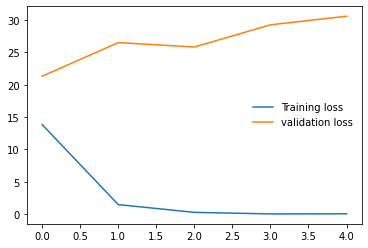

In [25]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [26]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [27]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [28]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78       130
           1       0.98      0.99      0.99      1949

    accuracy                           0.97      2079
   macro avg       0.91      0.86      0.88      2079
weighted avg       0.97      0.97      0.97      2079



#### Thank you very much for reading.
### পড়ার জন্য আপনাকে অনেক ধন্যবাদ।

In [29]:
 from sklearn import metrics

In [30]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)



In [31]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


In [32]:
import matplotlib.pyplot as plt



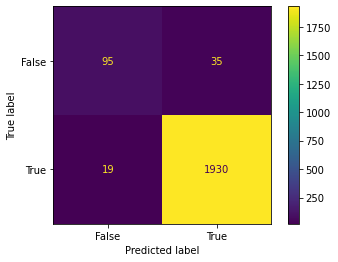

In [33]:
cm_display.plot()
plt.show()